# Trabajo práctico 3: forma y función en el universo Pokémon

Los enunciados del TP 3 son los siguientes:

1.   Usar el criterio de la Silueta para verificar que hay un máximo local cerca de k=8 clusters. Aplicar el algoritmo kmeans con k=8 clusters sobre los datos de *sprites* (matriz *data*).
2.   Visualizar las primeras dos componentes de la matriz de *sprites*, pintando con un color distinto los datos que pertenezcan a cada cluster, e indicando con cruces la posición de los centroides (ayuda: el código para hacer esto se encuentra en el notebook de clustering que vimos en clase).
3.   Visualizar los primeros 10 elementos de cada cluster. 
4.   En un mismo gráfico de barras, mostrar el valor promedio de los atributos *HP*, *Attack*, *Defense* y *Speed* de cada cluster. ¿Cuál es el cluster de Pokémones más fuertes?
5.   Hacer lo mismo que en el ítem anterior, pero con el tamaño promedio de los Pokémones por cluster (el tamaño se define como la cantidad de entradas no vacías en la fila correspondiente al *sprite* de ese Pokémon en la matriz data). ¿Son los Pokémones más grandes los más fuertes?
6.   Hacer gráficos de torta con la proporción de Pokémones legendarios/no legendarios por cluster. ¿Tiene el cluster de Pokémones más fuertes más legendarios que los otros? 

**Optativo**

7.   Entrenar, evaluar y determinar la performance de un modelo de aprendizaje supervisado para predecir alguna característica de los Pokémones en base a sus *sprites*. Puede ser, por ejemplo, un modelo de regresión (predecir *HP*, *Attack*, *Defense*, *Speed*), un modelo de clasificación binaria (legendario o no legendario), o un modelo de clasificación multiclase (tipo del Pokémon: tierra, hielo, agua, fuego, etc).


# Resolucion

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import random

RANDOM_SEED = 78945613
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

filename = 'pokemon_imagenes.p'

file = open(filename, 'rb')
data = pickle.load(file)
file.close()

nombres = data['nombres']
imagenes = data['imagenes']

filename = 'pokemon_dataframe.csv'
df = pd.read_csv(filename)
df.head()

data = np.zeros((len(nombres),56*68))

for n, img in enumerate(imagenes):
    img.resize(56*68)
    data[n,:] = img


## 1. Usar el criterio de la Silueta para verificar que hay un máximo local cerca de k=8 clusters. Aplicar el algoritmo kmeans con k=8 clusters sobre los datos de sprites (matriz data).

In [2]:
# Creación del modelo de PCA con 100 componentes
pca = PCA()

# Ajuste y transformación de los datos
pca.fit(data)
X_pca = pca.transform(data)

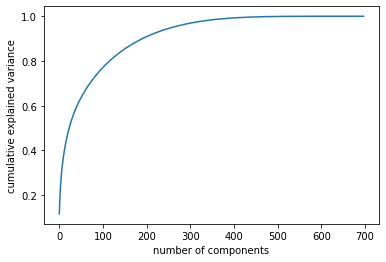

In [3]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [4]:
# Choosing 116 dimensions

pca = PCA(116)
X_pca = pca.fit_transform(data)

Text(0, 0.5, 'Segunda componente principal')

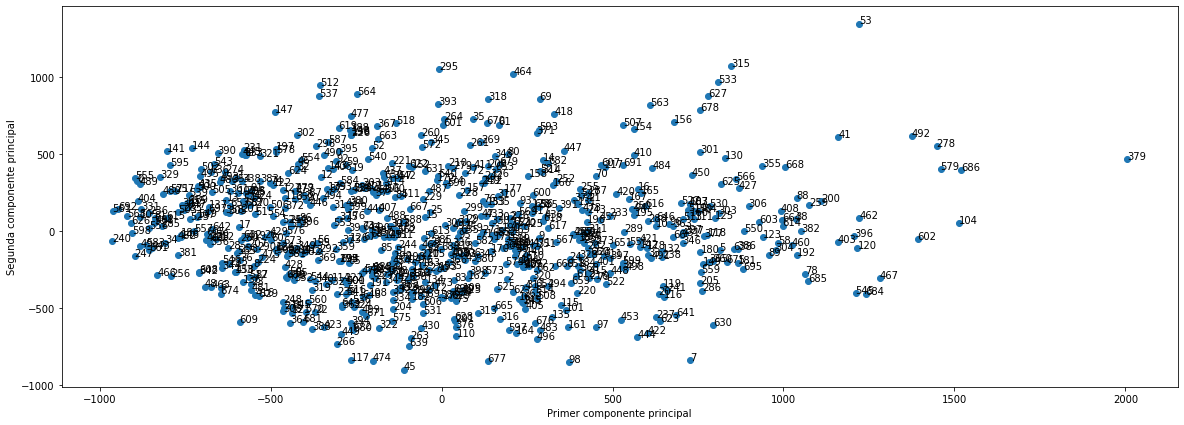

In [5]:
fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1])

# Por cada dato escribimos a qué instancia corresponde
for i in range(data.shape[0]):
    ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

In [6]:
# importamos el puntaje de silhouette
from sklearn.metrics import silhouette_score

In [7]:
# Creamos una lista para guardar de los coeficientes de silhouette para cada valor de k
silhouette_coefficients = []

# Se necesita tener al menos 2 clusters y a los sumo N-1 (con N el numero de muestras) para obtener coeficientes de Silohuette
for k in range(2, 20):
    kkkmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kkkmeans.fit(X_pca)
    score = silhouette_score(X_pca, kkkmeans.labels_)
    silhouette_coefficients.append(score)

Text(0, 0.5, 'Promedio coeficientes de Silhouette')

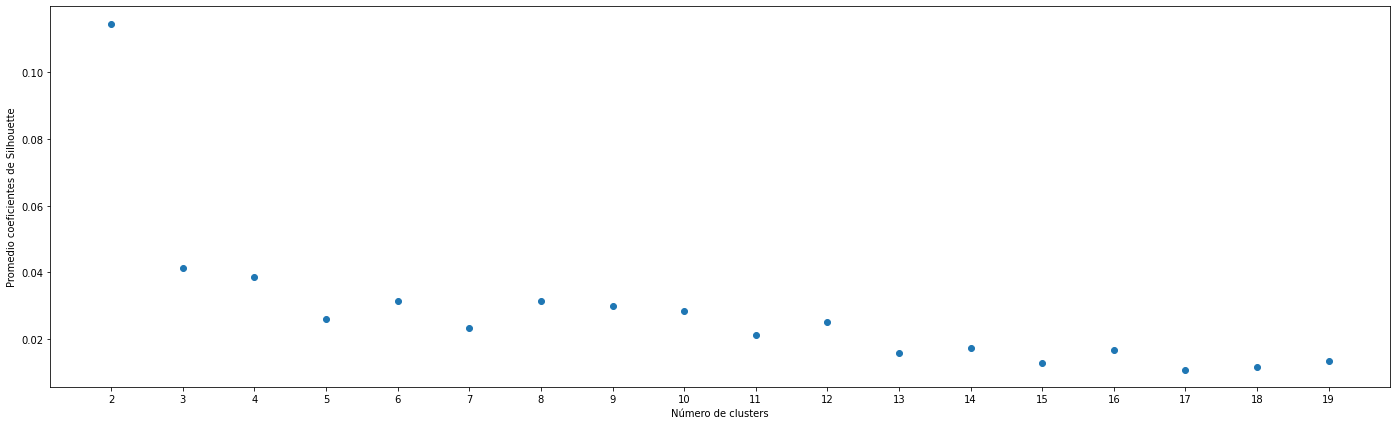

In [8]:
fig, ax = plt.subplots(figsize = (24, 7))

# estas lineas son el grafico de SSEvsK
ax.scatter(range(2, 20), silhouette_coefficients)            
ax.set_xticks(range(2, 20))
ax.set_xlabel("Número de clusters")
ax.set_ylabel("Promedio coeficientes de Silhouette")

In [9]:
[(i[0]+2, i[1]) for i in list(enumerate(silhouette_coefficients))]

[(2, 0.1146702708692279),
 (3, 0.0414293421464351),
 (4, 0.03852750200596509),
 (5, 0.025996211816217356),
 (6, 0.031436162091325395),
 (7, 0.023352404519583522),
 (8, 0.031296815293382345),
 (9, 0.029889745540583205),
 (10, 0.028451956905326564),
 (11, 0.021344410764520105),
 (12, 0.025137792576026746),
 (13, 0.015885485195481518),
 (14, 0.017169629650761097),
 (15, 0.012855663269569712),
 (16, 0.016608069941200777),
 (17, 0.010851692731569957),
 (18, 0.011604913732971695),
 (19, 0.013364720902936111)]

In [10]:
kmeans = KMeans(n_clusters=8, random_state=RANDOM_SEED)
kmeans.fit(X_pca)
score = silhouette_score(X_pca, kmeans.labels_)

In [11]:
score

0.031296815293382345

# 2. Visualizar las primeras dos componentes de la matriz de sprites, pintando con un color distinto los datos que pertenezcan a cada cluster, e indicando con cruces la posición de los centroides (ayuda: el código para hacer esto se encuentra en el notebook de clustering que vimos en clase).

In [12]:
np.unique(kmeans.labels_[:10], return_counts=True) 

(array([1, 2, 3, 5, 6, 7], dtype=int32), array([2, 3, 1, 1, 1, 2]))

Idealmente queríamos tener una sola etiqueta en las primeras 10 muestras ya que corresponden a las fotos tomadas a una dada persona. Sin embargo obtuvimos 6 etiquetas distintas. 

Veamos qué es lo que está pasando. Vamos a plotear el dataset en el espacio de las primeras dos componentes principales pero además vamos a asignarle un color a cada sample que corresponde a la etiqueta asignada por el modelo. También vamos a graficar con una "X" el centroid de cada cluster.

Para acceder a la posición de los centroids en el espacio de 100 PCs usamos 'kmeans.cluster_centers_'

In [13]:
centroids = kmeans.cluster_centers_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Segunda componente principal')

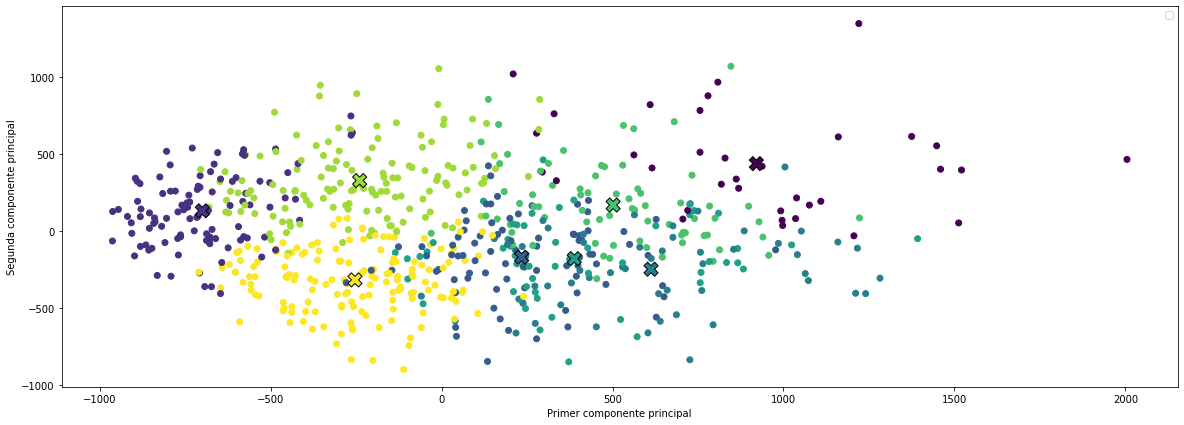

In [14]:
# Este bloque es similar al anterior pero agregando color a cada sample en el scatter plot según la etiqueta asignada

fig, ax = plt.subplots(figsize = (20, 7))

# Hacemos un scatter plot de cada uno de los datos
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
ax.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=200, linewidths=1,
            c=np.unique(kmeans.labels_), edgecolors='black')
ax.legend()

## Por cada dato escribimos a qué instancia corresponde
#for i in range(data.shape[0]):
#  ax.text(X_pca[i, 0], X_pca[i, 1], s = i)

ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

# 3. Visualizar los primeros 10 elementos de cada cluster

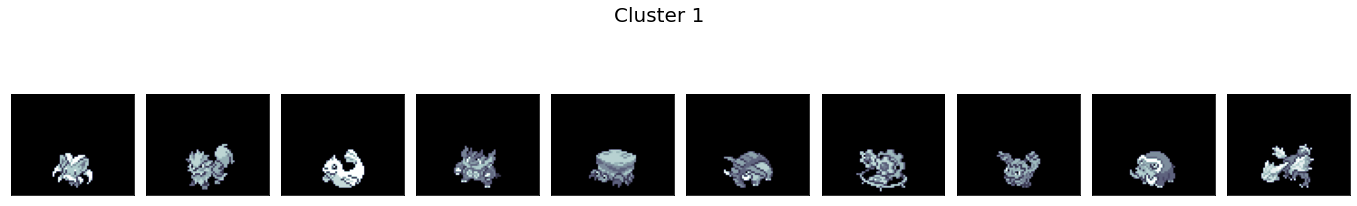

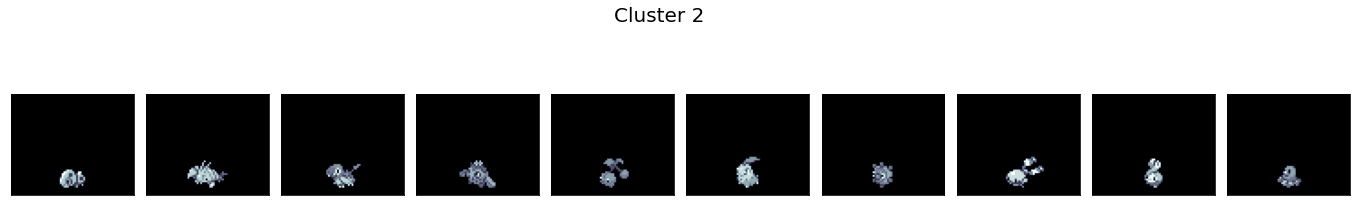

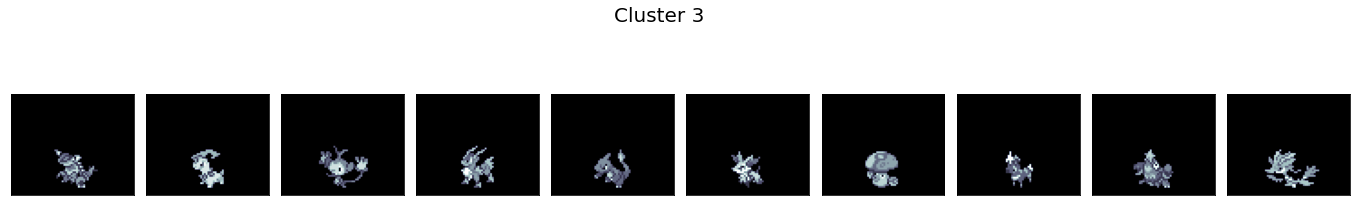

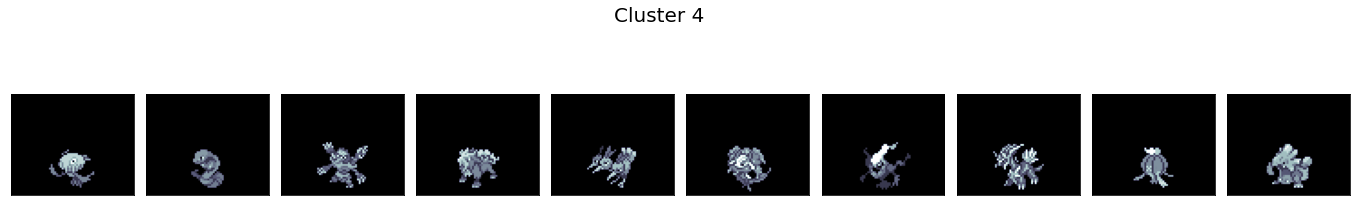

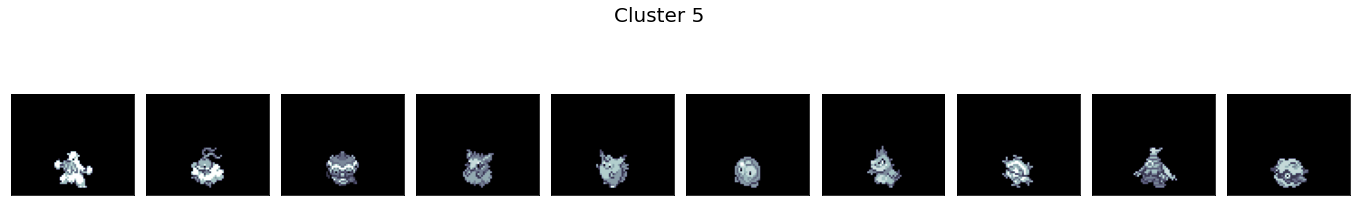

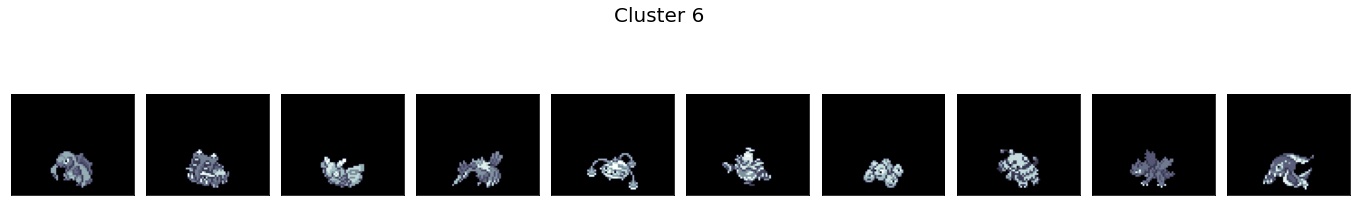

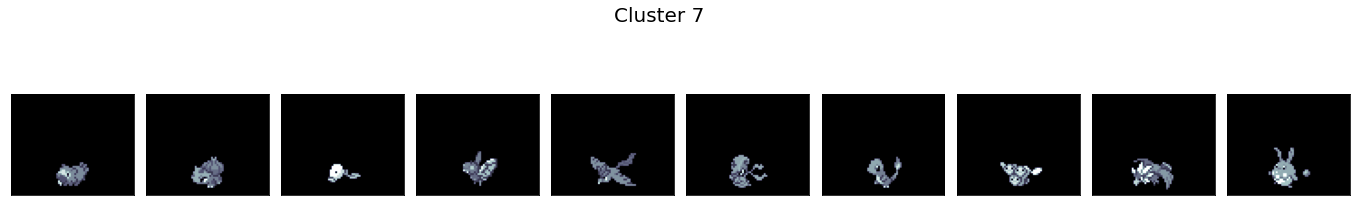

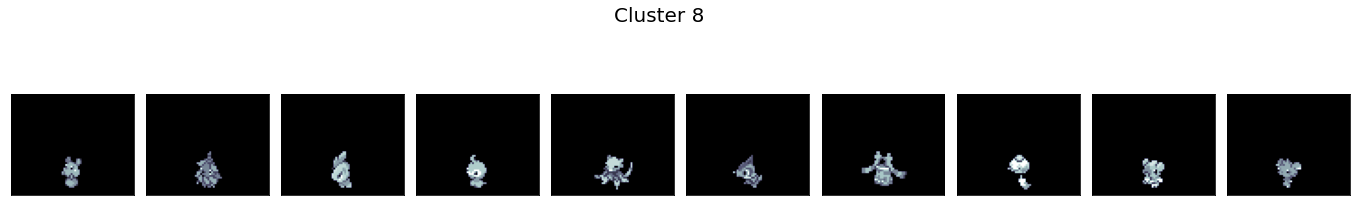

In [15]:
labels = kmeans.labels_

for i in range(8):
    num = 10
    index = np.nonzero(labels==i)[0]
    pokemons = data[index].reshape(len(index),56*68)
    fig, axes = plt.subplots(1, num, figsize=(24, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    fig.suptitle("Cluster " + str(i+1), fontsize=20)
    for i, ax in enumerate(axes.flat):
        ax.imshow(pokemons[i].reshape((56, 68)), cmap='bone')

# 4. En un mismo gráfico de barras, mostrar el valor promedio de los atributos *HP*, *Attack*, *Defense* y *Speed* de cada cluster. ¿Cuál es el cluster de Pokémones más fuertes?

In [16]:
df['label'] = labels

<AxesSubplot:xlabel='label'>

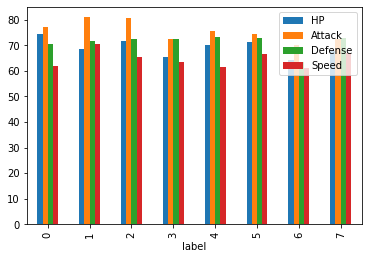

In [17]:
df.groupby('label').mean()[['HP','Attack','Defense','Speed']].plot.bar()

In [22]:
df.groupby('label').mean()[['HP','Attack','Defense','Speed']]

,HP,Attack,Defense,Speed
label,,,,
0,74.485714,76.971429,70.400000,62.000000
1,68.510000,80.940000,71.520000,70.680000
2,71.602410,80.650602,72.530120,65.349398
3,65.400000,72.636364,72.309091,63.400000
4,70.090909,75.418182,73.381818,61.581818
5,71.356164,74.602740,72.890411,66.602740
6,64.187050,69.942446,63.582734,61.179856
7,67.639241,72.297468,72.930380,67.018987


Si se define a la fuerza como el poder de ataque maximo, este seria el cluster con `label=1`. Seguido de cerca por el numero 2

# 5. Hacer lo mismo que en el ítem anterior, pero con el tamaño promedio de los Pokémones por cluster (el tamaño se define como la cantidad de entradas no vacías en la fila correspondiente al *sprite* de ese Pokémon en la matriz data). ¿Son los Pokémones más grandes los más fuertes?

In [18]:
size = [np.count_nonzero(i) for i in data]

In [19]:
df['size'] = size

In [24]:
df.groupby('label').mean()[['size','Attack']]

,size,Attack
label,,
0,320.542857,76.971429
1,122.930000,80.940000
2,215.614458,80.650602
3,274.600000,72.636364
4,222.436364,75.418182
5,274.657534,74.602740
6,179.690647,69.942446
7,157.740506,72.297468


In [29]:
df.groupby('label').mean()[['size','Attack']].corr()

,size,Attack
size,1.000000,-0.100527
Attack,-0.100527,1.000000


Si mantememos la definicion de fuerza, como el valor de ataque, vemos que no hay necesariamente una correlacion entre el tamano de los pokemones con la fuerza del mismo

# 6. Hacer gráficos de torta con la proporción de Pokémones legendarios/no legendarios por cluster. ¿Tiene el cluster de Pokémones más fuertes más legendarios que los otros?

In [21]:
df[['Legendary','label']].groupby('label').mean()

,Legendary
label,
0,0.085714
1,0.050000
2,0.048193
3,0.036364
4,0.054545
5,0.041096
6,0.028777
7,0.088608


Se puede ver que el cluster mas fuerte (1), no tiene la proporcion mas alta de pokemones legendarios